In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from utils import get_features

## Train Test Split

In [97]:
dir = '/Users/daixinming/Projects/AppliedStatisticsII/applied_stats_project/data/sd302/images/challengers/A/roll/img_l2_feature_extractions_png/img_l1_feature_extractions/freq'
featuers, label, size = get_features(dir, num_subjects=5)
X_train, X_test, y_train, y_test = train_test_split(featuers, label, test_size=0.2, random_state=42)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='saga',random_state=0, max_iter=500).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.15


In [100]:
featuers, label, image_size = get_features(dir, seed=3, num_subjects=10)

In [101]:
image_size

(70, 52)

## SVM

In [46]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [51]:
train_scores = []
test_scores = []
for j in range(20, 40):
    print(f"{j}-th data set")
    featuers, label,_ = get_features(dir, seed=j, num_subjects=3)

    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(featuers, label, test_size=0.2, random_state=i)
        svc = svm.SVC()
        svc.fit(X_train, y_train)
        svc = OneVsRestClassifier(svm.SVC(kernel='rbf')).fit(X_train, y_train)
        train_scores.append(svc.score(X_train, y_train)) 
        test_scores.append(svc.score(X_test, y_test))

print(np.average(train_scores), np.average(test_scores))


20-th data set
21-th data set
22-th data set
23-th data set
24-th data set
25-th data set
26-th data set
27-th data set
28-th data set
29-th data set
30-th data set
31-th data set
32-th data set
33-th data set
34-th data set
35-th data set
36-th data set
37-th data set
38-th data set
39-th data set
0.9297192028985506 0.48916666666666664


In [86]:
featuers[0].shape

(3500,)

## Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

# ----- 1. Custom Dataset class -----
class FingerprintDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 2. Simple CNN model -----
class FingerprintClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(FingerprintClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))      # Downsample
        x = self.pool(F.relu(self.conv2(x)))      # Downsample
        x = self.adaptive_pool(x)                 # Output shape: (B, 32, 4, 4)
        x = self.dropout(x)
        x = torch.flatten(x, 1)                   # Shape: (B, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----- 3. Training loop -----
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# ----- 4. Evaluation function -----
def evaluate_model(model, dataloader, device, get_embeddings=False):
    model.eval()
    correct, total = 0, 0

    embeddings = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if get_embeddings:
                embs = model.get_embedding(inputs)  # shape: (B, D)
                embeddings.extend(embs.detach().cpu())  # append each embedding tensor to the list

    if get_embeddings:
        return embeddings, labels  # both are lists of tensors
    else:
        return correct / total
    

In [8]:
# Assuming X has shape (n_samples, 1, 70, 52) and y has labels 0–9
featuers, label, img_size = get_features(1, flatten=False)
X_train, X_test, y_train, y_test = train_test_split(featuers, label, test_size=0.2, random_state=42)

dataset = FingerprintDataset(featuers, label)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FingerprintClassifier(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in range(10):
    train_model(model, train_loader, optimizer, criterion, device)
    acc = evaluate_model(model, val_loader, device)
    print(f"Epoch {epoch+1}: Val Accuracy = {acc:.4f}")


Epoch 1: Val Accuracy = 0.0500
Epoch 2: Val Accuracy = 0.0500
Epoch 3: Val Accuracy = 0.1000
Epoch 4: Val Accuracy = 0.0500
Epoch 5: Val Accuracy = 0.0500
Epoch 6: Val Accuracy = 0.1000
Epoch 7: Val Accuracy = 0.1500
Epoch 8: Val Accuracy = 0.1500
Epoch 9: Val Accuracy = 0.1500
Epoch 10: Val Accuracy = 0.2000


## GMM

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=len(set(label)), random_state=0).fit(featuers)

In [ ]:
gmm_labels = gm.predict(featuers)

In [33]:
from sklearn.metrics import normalized_mutual_info_score
nmi = normalized_mutual_info_score(featuers[0].reshape(-1), gmm_labels)
print(f"Normalized Mutual Information: {nmi:.4f}")

Normalized Mutual Information: 0.7063


## QDA

In [44]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
lda = QuadraticDiscriminantAnalysis(reg_param=0.001)
lda.fit(X_train, y_train)
print(lda.score(X_train, y_train))
print(lda.score(X_test, y_test))

0.925
0.15


/Users/daixinming/Projects/AppliedStatisticsII/fingerprints/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/daixinming/Projects/AppliedStatisticsII/fingerprints/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/daixinming/Projects/AppliedStatisticsII/fingerprints/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/daixinming/Projects/AppliedStatisticsII/fingerprints/lib/python3.9/site-packages/sklearn/discriminant_analysis.

## K means

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(featuers)

In [49]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(label, kmeans.labels_)
print(f"Normalized Mutual Information: {nmi:.4f}")

Normalized Mutual Information: 0.3085


## NMF

In [58]:
from sklearn.decomposition import NMF
model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(featuers)
H = model.components_

/Users/daixinming/Projects/AppliedStatisticsII/fingerprints/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [59]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
from scipy.spatial.distance import cdist
def assign_to_closest_basis(X: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Assigns each row of X to the index of the closest row in H.

    Args:
        X: np.ndarray of shape (n_samples, n_features)
        H: np.ndarray of shape (n_components, n_features)

    Returns:
        assignments: np.ndarray of shape (n_samples,), where each entry is the index of the closest row in H
    """
    distances = cdist(X, H, metric='euclidean')  # shape: (n_samples, n_components)
    assignments = np.argmin(distances, axis=1)   # index of closest H row for each X row
    return np.argmax(1 - cdist(X, H, metric='cosine'), axis=1)

In [61]:
assignment = assign_to_closest_basis(featuers, H)

In [64]:
assignment

array([2, 2, 0, 0, 2, 0, 6, 7, 2, 0, 0, 0, 2, 6, 0, 0, 2, 0, 2, 2, 4, 2,
       2, 6, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 4, 2, 6, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 6, 3, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 2, 0, 6, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0])

In [65]:
nmi = normalized_mutual_info_score(label, assignment)
print(f"Normalized Mutual Information: {nmi:.4f}")

Normalized Mutual Information: 0.0989


# Plots

In [82]:
import numpy as np
import json

def summarize_results(dir:str, result_list: dict):
    """
    Summarizes the average train/test scores for each model across multiple datasets.

    Args:
        result_list (list): Dictionary mapping dataset names (e.g., 'class_3') to results dicts.

    Returns:
        summary (dict): Nested dictionary with structure:
            {dataset_name: {model_name: (train_avg, test_avg)}}
    """
    summary = {}

    for dataset_name in result_list:
        location = None

        path = os.path.join(dir, dataset_name+'.json')
        with open(path, 'r') as f:
            results = json.load(f)

        dataset_summary = {}
        print(f"\n=== Dataset: {dataset_name} ===")
        for model_name, scores in results.items():

            # if location is None:
            location = np.argmax(np.array(scores['test']))

            train_avg = scores['train'][location]
            test_avg = scores['test'][location]
            dataset_summary[model_name] = (train_avg, test_avg)
            print(f"{model_name}: Train = {train_avg:.4f}, Test = {test_avg:.4f}")
        summary[dataset_name] = dataset_summary

    return summary

In [83]:
all_results = ['class_10',  'class_5', 'class_3']
dir = '/Users/daixinming/Projects/AppliedStatisticsII/applied_stats_project/analysis'
summary = summarize_results(dir, all_results)


=== Dataset: class_10 ===
SVM: Train = 1.0000, Test = 0.4333
LogReg: Train = 1.0000, Test = 0.4667
QDA: Train = 0.8714, Test = 0.3667

=== Dataset: class_5 ===
SVM: Train = 1.0000, Test = 0.7333
LogReg: Train = 1.0000, Test = 0.8000
QDA: Train = 0.9412, Test = 0.5333

=== Dataset: class_3 ===
SVM: Train = 1.0000, Test = 1.0000
LogReg: Train = 1.0000, Test = 1.0000
QDA: Train = 1.0000, Test = 0.7778


In [91]:
import matplotlib.pyplot as plt

def plot_test_accuracy(summary):
    """
    Plot test accuracy vs number of classes for different models.
    Each model has a different line style and marker style.
    """
    model_names = list(next(iter(summary.values())).keys())  # get model names
    class_numbers = [int(name.split('_')[1]) for name in summary.keys()]  # extract class number
    class_numbers.sort()

    plt.figure(figsize=(4,4))

    # Define different line styles and marker styles
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'x', '*']

    for idx, model in enumerate(model_names):
        accuracies = []
        for c in sorted(summary.keys(), key=lambda x: int(x.split('_')[1])):
            _, test_acc = summary[c][model]
            accuracies.append(test_acc)
        
        plt.plot(
            class_numbers,
            accuracies,
            linestyle=line_styles[idx % len(line_styles)],
            marker=markers[idx % len(markers)],
            label=model,
            markersize=7
        )

    plt.xlabel('Number of Classes')
    plt.ylabel('Test Accuracy')
    plt.xticks([3, 5, 10])
    plt.title('Test Accuracy vs Number of Classes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


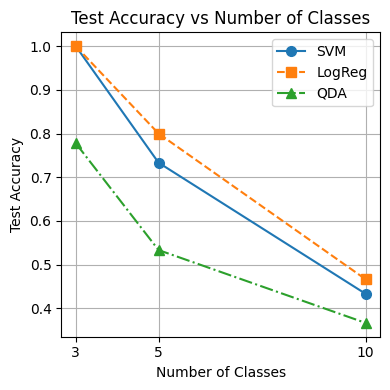

In [92]:
plot_test_accuracy(summary)